<a href="https://colab.research.google.com/github/digwit678/DIGCREAT_AUDIO_PROCESSION/blob/main/ddsp/colab/tutorials/3_training_string_mallet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/magenta/ddsp/blob/main/ddsp/colab/tutorials/3_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


##### Copyright 2021 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");





In [1]:
# Copyright 2021 Google LLC. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# DDSP Training

This notebook demonstrates the libraries in [https://github.com/magenta/ddsp/tree/master/ddsp/training](https://github.com/magenta/ddsp/tree/master/ddsp/training). It is a simple example, overfitting a single audio sample, for educational purposes. 

_For a full training pipeline please use [ddsp/training/ddsp_run.py](https://github.com/magenta/ddsp/blob/main/ddsp/training/README.md#train-1) as in the [train_autoencoder.ipynb](https://github.com/magenta/ddsp/blob/main/ddsp/colab/demos/train_autoencoder.ipynb)_.



In [2]:
# Install and import dependencies
%tensorflow_version 2.x
!pip install -qU ddsp

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import time

import ddsp
from ddsp.training import (data, decoders, encoders, models, preprocessing, 
                           train_util, trainers)
from ddsp.colab.colab_utils import play, specplot, DEFAULT_SAMPLE_RATE
import gin
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

sample_rate = DEFAULT_SAMPLE_RATE  # 16000

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# Get a batch of data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os

from absl import logging
from ddsp.spectral_ops import CREPE_FRAME_SIZE
from ddsp.spectral_ops import CREPE_SAMPLE_RATE
from ddsp.spectral_ops import get_framed_lengths
import gin
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

class DataProvider(object):
  """Base class for returning a dataset."""

  def __init__(self, sample_rate, frame_rate):
    """DataProvider constructor.
    Args:
      sample_rate: Sample rate of audio in the dataset.
      frame_rate: Frame rate of features in the dataset.
    """
    self._sample_rate = sample_rate
    self._frame_rate = frame_rate

  @property
  def sample_rate(self):
    """Return dataset sample rate, must be defined in the constructor."""
    return self._sample_rate

  @property
  def frame_rate(self):
    """Return dataset feature frame rate, must be defined in the constructor."""
    return self._frame_rate

  def get_dataset(self, shuffle):
    """A method that returns a tf.data.Dataset."""
    raise NotImplementedError

  def get_batch(self,
                batch_size,
                shuffle=True,
                repeats=-1,
                drop_remainder=True):
    """Read dataset.
    Args:
      batch_size: Size of batch.
      shuffle: Whether to shuffle the examples.
      repeats: Number of times to repeat dataset. -1 for endless repeats.
      drop_remainder: Whether the last batch should be dropped.
    Returns:
      A batched tf.data.Dataset.
    """
    dataset = self.get_dataset(shuffle)
    dataset = dataset.repeat(repeats)
    dataset = dataset.batch(batch_size, drop_remainder=drop_remainder)
    dataset = dataset.prefetch(buffer_size=_AUTOTUNE)
    return dataset

class TFRecordProvider(DataProvider):
  """Class for reading TFRecords and returning a dataset."""

  def __init__(self,
               file_pattern=None,
               example_secs=4,
               sample_rate=16000,
               frame_rate=250,
               centered=False):
    """RecordProvider constructor."""
    super().__init__(sample_rate, frame_rate)
    self._file_pattern = file_pattern or self.default_file_pattern
    self._audio_length = example_secs * sample_rate
    self._audio_16k_length = example_secs * CREPE_SAMPLE_RATE
    self._feature_length = self.get_feature_length(centered)


  def get_feature_length(self, centered):
    """Take into account center padding to get number of frames."""
    # Number of frames is independent of frame size for "center/same" padding.
    hop_size = CREPE_SAMPLE_RATE / self.frame_rate
    padding = 'center' if centered else 'same'
    return get_framed_lengths(
        self._audio_16k_length, CREPE_FRAME_SIZE, hop_size, padding)[0]

  @property
  def default_file_pattern(self):
    """Used if file_pattern is not provided to constructor."""
    raise NotImplementedError(
        'You must pass a "file_pattern" argument to the constructor or '
        'choose a FileDataProvider with a default_file_pattern.')

  def get_dataset(self, shuffle=True):
    """Read dataset.
    Args:
      shuffle: Whether to shuffle the files.
    Returns:
      dataset: A tf.dataset that reads from the TFRecord.
    """
    def parse_tfexample(record):
      return tf.io.parse_single_example(record, self.features_dict)

    filenames = tf.data.Dataset.list_files(self._file_pattern, shuffle=shuffle)
    dataset = filenames.interleave(
        map_func=tf.data.TFRecordDataset,
        cycle_length=40,
        num_parallel_calls=_AUTOTUNE)
    dataset = dataset.map(parse_tfexample, num_parallel_calls=_AUTOTUNE)
    return dataset

  @property
  def features_dict(self):
    """Dictionary of features to read from dataset."""
    return {
        'audio':
            tf.io.FixedLenFeature([self._audio_length], dtype=tf.float32),
        'f0/hz':
            tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
        'f0/confidence':
            tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
        'loudness/db':
            tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
    }

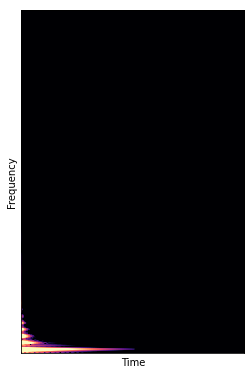

In [5]:
# Get a single example from NSynth.
# Takes a few seconds to load from GCS.
import glob

_AUTOTUNE = tf.data.experimental.AUTOTUNE

filenames_full = glob.glob("/content/drive/MyDrive/NSYNTH_GAN/string/train/*.tfrecord")
data_provider = TFRecordProvider(
    "/content/drive/MyDrive/NSYNTH_GAN/string/train/*.tfrecord"
)
filenames_full_2 = glob.glob("/content/drive/MyDrive/NSYNTH_GAN/mallet/train/*.tfrecord")
data_provider_2 = TFRecordProvider(
    "/content/drive/MyDrive/NSYNTH_GAN/mallet/train/*.tfrecord"
)

dataset = data_provider.get_batch(batch_size=1, shuffle=False).take(1).repeat()
dataset2 = data_provider_2.get_batch(batch_size=1, shuffle=False).take(1)
batch = next(iter(dataset2))
audio = batch['audio']
n_samples = audio.shape[1]

specplot(audio)
play(audio)

In [6]:
#type(dataset)

# Get a distribution strategy


In [7]:
# Copyright 2022 The DDSP Authors.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

"""Library of Trainer objects that define traning step and wrap optimizer."""

import time

from absl import logging
from ddsp.training import train_util
import gin
import tensorflow.compat.v2 as tf

gin.enter_interactive_mode()

@gin.configurable

class Trainer2(object):
  """Class to bind an optimizer, model, strategy, and training step function."""

  def __init__(self,
               model,
               strategy,
               checkpoints_to_keep=100,
               learning_rate=0.001,
               lr_decay_steps=10000,
               lr_decay_rate=0.98,
               grad_clip_norm=3.0,
               restore_keys=None):
    """Constructor.

    Args:
      model: Model to train.
      strategy: A distribution strategy.
      checkpoints_to_keep: Max number of checkpoints before deleting oldest.
      learning_rate: Scalar initial learning rate.
      lr_decay_steps: Exponential decay timescale.
      lr_decay_rate: Exponential decay magnitude.
      grad_clip_norm: Norm level by which to clip gradients.
      restore_keys: List of names of model properties to restore. If no keys are
        passed, restore the whole model.
    """
    self.model = model
    self.strategy = strategy
    self.checkpoints_to_keep = checkpoints_to_keep
    self.grad_clip_norm = grad_clip_norm
    self.restore_keys = restore_keys

    # Create an optimizer.
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=learning_rate,
        decay_steps=lr_decay_steps,
        decay_rate=lr_decay_rate)

    with self.strategy.scope():
      self.optimizer = tf.keras.optimizers.Adam(lr_schedule)

  def get_checkpoint(self, model=None):
    """Model arg can also be a tf.train.Checkpoint(**dict(submodules))."""
    model = model or self.model  # Default to full model.
    return tf.train.Checkpoint(model=model, optimizer=self.optimizer)

  def save(self, save_dir):
    """Saves model and optimizer to a checkpoint."""
    # Saving weights in checkpoint format because saved_model requires
    # handling variable batch size, which some synths and effects can't.
    start_time = time.time()
    checkpoint = self.get_checkpoint()
    manager = tf.train.CheckpointManager(
        checkpoint, directory=save_dir, max_to_keep=self.checkpoints_to_keep)
    step = self.step.numpy()
    manager.save(checkpoint_number=step)
    logging.info('Saved checkpoint to %s at step %s', save_dir, step)
    logging.info('Saving model took %.1f seconds', time.time() - start_time)

  def restore(self, checkpoint_path, restore_keys=None):
    """Restore model and optimizer from a checkpoint if it exists.

    Args:
      checkpoint_path: Path to checkpoint file or directory.
      restore_keys: Optional list of strings for submodules to restore.

    Raises:
      FileNotFoundError: If no checkpoint is found.
    """
    logging.info('Restoring from checkpoint...')
    start_time = time.time()

    # Prefer function args over object properties.
    restore_keys = restore_keys or self.restore_keys
    if restore_keys is None:
      # If no keys are passed, restore the whole model.
      model = self.model
      logging.info('Trainer restoring the full model')
    else:
      # Restore only sub-modules by building a new subgraph.
      restore_dict = {k: getattr(self.model, k) for k in restore_keys}
      model = tf.train.Checkpoint(**restore_dict)

      logging.info('Trainer restoring model subcomponents:')
      for k, v in restore_dict.items():
        log_str = 'Restoring {}: {}'.format(k, v)
        logging.info(log_str)

    # Restore from latest checkpoint.
    checkpoint = self.get_checkpoint(model)
    latest_checkpoint = train_util.get_latest_checkpoint(checkpoint_path)
    # checkpoint.restore must be within a strategy.scope() so that optimizer
    # slot variables are mirrored.
    with self.strategy.scope():
      if restore_keys is None:
        checkpoint.restore(latest_checkpoint)
      else:
        checkpoint.restore(latest_checkpoint).expect_partial()
      logging.info('Loaded checkpoint %s', latest_checkpoint)
    logging.info('Loading model took %.1f seconds', time.time() - start_time)

  @property
  def step(self):
    """The number of training steps completed."""
    return self.optimizer.iterations

  def psum(self, x, axis=None):
    """Sum across processors."""
    return self.strategy.reduce(tf.distribute.ReduceOp.SUM, x, axis=axis)

  def run(self, fn, *args, **kwargs):
    """Distribute and run function on processors."""
    return self.strategy.run(fn, args=args, kwargs=kwargs)

  def build(self, batch):
    """Build the model by running a distributed batch through it."""
    logging.info('Building the model...')
    #batch = rename_features(batch)
    _ = self.run(tf.function(self.model.__call__), batch)
    self.model.summary()

  def distribute_dataset(self, dataset):
    """Create a distributed dataset."""
    if isinstance(dataset, tf.data.Dataset):
      return self.strategy.experimental_distribute_dataset(dataset)
    else:
      return dataset

  @tf.function
  def train_step(self, inputs):
    """Distributed training step. Cust"""
    # Wrap iterator in tf.function, slight speedup passing in iter vs batch.
    batch = next(inputs) if hasattr(inputs, '__next__') else inputs
    batch = rename_features(batch)
    losses = self.run(self.step_fn, batch)
    # Add up the scalar losses across replicas.
    n_replicas = self.strategy.num_replicas_in_sync
    return {k: self.psum(v, axis=None) / n_replicas for k, v in losses.items()}

  @tf.function
  def step_fn(self, batch):
    #batch = rename_features(batch)
    #print(batch)
    """Per-Replica training step."""
    with tf.GradientTape() as tape:
      _, losses = self.model(batch, return_losses=True, training=True)
    # Clip and apply gradients.
    grads = tape.gradient(losses['total_loss'], self.model.trainable_variables)
    grads, _ = tf.clip_by_global_norm(grads, self.grad_clip_norm)
    self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
    return losses


@gin.configurable
def get_trainer_class(trainer_class=Trainer2):
  """Gin configurable function get a 'global' trainer for use in ddsp_run.py.

  Args:
    trainer_class: A trainer class such as `Trainer`.

  Returns:
    The 'global' trainer class specifieed in the gin config.
  """
  return trainer_class


In [8]:
strategy = train_util.get_strategy()

In [9]:
print(batch["f0/confidence"])
batch["f0/confidence"]

tf.Tensor(
[[0.93773353 0.9452007  0.9449954  0.94677985 0.9500225  0.9442419
  0.9516877  0.9541291  0.95147645 0.9489774  0.9571699  0.9511798
  0.9456401  0.95614195 0.95160943 0.9398309  0.94929576 0.9497913
  0.9439302  0.9446571  0.9476501  0.9394771  0.9335408  0.9433749
  0.9443735  0.9304441  0.9416572  0.93890077 0.93091744 0.94296217
  0.94381714 0.93011    0.9392348  0.93392503 0.929463   0.92636013
  0.9317428  0.93493485 0.9192259  0.937116   0.9326004  0.9166105
  0.9338255  0.9342736  0.923508   0.9348152  0.9357728  0.9272884
  0.92266345 0.9256804  0.9312862  0.92052066 0.9327774  0.93385607
  0.9126848  0.9234666  0.9220051  0.9135505  0.93121195 0.93198216
  0.92891073 0.9284665  0.93140155 0.9248129  0.9141939  0.9240655
  0.92860323 0.919415   0.93237054 0.9278046  0.9117222  0.92837995
  0.9234501  0.9193841  0.93269217 0.9325123  0.9263015  0.92211556
  0.9274379  0.92752564 0.91878635 0.92827904 0.93128616 0.9154526
  0.92520875 0.920659   0.9121195  0.93025506

<tf.Tensor: shape=(1, 1000), dtype=float32, numpy=
array([[0.93773353, 0.9452007 , 0.9449954 , 0.94677985, 0.9500225 ,
        0.9442419 , 0.9516877 , 0.9541291 , 0.95147645, 0.9489774 ,
        0.9571699 , 0.9511798 , 0.9456401 , 0.95614195, 0.95160943,
        0.9398309 , 0.94929576, 0.9497913 , 0.9439302 , 0.9446571 ,
        0.9476501 , 0.9394771 , 0.9335408 , 0.9433749 , 0.9443735 ,
        0.9304441 , 0.9416572 , 0.93890077, 0.93091744, 0.94296217,
        0.94381714, 0.93011   , 0.9392348 , 0.93392503, 0.929463  ,
        0.92636013, 0.9317428 , 0.93493485, 0.9192259 , 0.937116  ,
        0.9326004 , 0.9166105 , 0.9338255 , 0.9342736 , 0.923508  ,
        0.9348152 , 0.9357728 , 0.9272884 , 0.92266345, 0.9256804 ,
        0.9312862 , 0.92052066, 0.9327774 , 0.93385607, 0.9126848 ,
        0.9234666 , 0.9220051 , 0.9135505 , 0.93121195, 0.93198216,
        0.92891073, 0.9284665 , 0.93140155, 0.9248129 , 0.9141939 ,
        0.9240655 , 0.92860323, 0.919415  , 0.93237054, 0.9278046

In [10]:
print(batch.keys())

dict_keys(['audio', 'f0/confidence', 'f0/hz', 'loudness/db'])


In [11]:

#batch[new_key] = batch.pop(old_key)

def rename_features(batch):
  batch['f0_confidence'] = batch.pop('f0/confidence')

  batch['f0_hz'] = batch.pop('f0/hz')

  batch['loudness_db'] = batch.pop('loudness/db')

  return batch

In [12]:
print(batch.keys())

dict_keys(['audio', 'f0/confidence', 'f0/hz', 'loudness/db'])


In [13]:
batch_keys = batch.keys()
new_keys = ['audio', 'f0_confidence', 'f0_hz', 'loudness_db']
print(zip(batch_keys,new_keys))
for key, key2 in zip(batch_keys,new_keys):
  print(key, key2)


audio audio
f0/confidence f0_confidence
f0/hz f0_hz
loudness/db loudness_db


In [14]:
print(audio)

tf.Tensor([[0.00445393 0.10546707 0.2777211  ... 0.         0.         0.        ]], shape=(1, 64000), dtype=float32)


# Get model and trainer

## python 

In [15]:
TIME_STEPS = 1000

# Create Neural Networks.
preprocessor = preprocessing.F0LoudnessPreprocessor(time_steps=TIME_STEPS)

decoder = decoders.RnnFcDecoder(rnn_channels = 256,
                                rnn_type = 'gru',
                                ch = 256,
                                layers_per_stack = 1,
                                input_keys = ('ld_scaled', 'f0_scaled'),
                                output_splits = (('amps', 1),
                                                 ('harmonic_distribution', 45),
                                                 ('noise_magnitudes', 45)))

# Create Processors.
harmonic = ddsp.synths.Harmonic(n_samples=n_samples, 
                                sample_rate=sample_rate,
                                name='harmonic')

noise = ddsp.synths.FilteredNoise(window_size=0,
                                  initial_bias=-10.0,
                                  name='noise')
add = ddsp.processors.Add(name='add')

# Create ProcessorGroup.
dag = [(harmonic, ['amps', 'harmonic_distribution', 'f0_hz']),
       (noise, ['noise_magnitudes']),
       (add, ['noise/signal', 'harmonic/signal'])]

processor_group = ddsp.processors.ProcessorGroup(dag=dag,
                                                 name='processor_group')


# Loss_functions
spectral_loss = ddsp.losses.SpectralLoss(loss_type='L1',
                                         mag_weight=1.0,
                                         logmag_weight=1.0)

with strategy.scope():
  # Put it together in a model.
  model = models.Autoencoder(preprocessor=preprocessor,
                             encoder=None,
                             decoder=decoder,
                             processor_group=processor_group,
                             losses=[spectral_loss])
  trainer2 = Trainer2(model, strategy, learning_rate=1e-3)

## or [`gin`](https://github.com/google/gin-config)

In [16]:
gin_string = """
import ddsp
import ddsp.training

# Preprocessor
models.Autoencoder.preprocessor = @preprocessing.F0LoudnessPreprocessor()
preprocessing.F0LoudnessPreprocessor.time_steps = 1000


# Encoder
models.Autoencoder.encoder = None

# Decoder
models.Autoencoder.decoder = @decoders.RnnFcDecoder()
decoders.RnnFcDecoder.rnn_channels = 256
decoders.RnnFcDecoder.rnn_type = 'gru'
decoders.RnnFcDecoder.ch = 256
decoders.RnnFcDecoder.layers_per_stack = 1
decoders.RnnFcDecoder.input_keys = ('ld_scaled', 'f0_scaled')
decoders.RnnFcDecoder.output_splits = (('amps', 1),
                                       ('harmonic_distribution', 20),
                                       ('noise_magnitudes', 20))

# ProcessorGroup
models.Autoencoder.processor_group = @processors.ProcessorGroup()

processors.ProcessorGroup.dag = [
  (@harmonic/synths.Harmonic(),
    ['amps', 'harmonic_distribution', 'f0_hz']),
  (@noise/synths.FilteredNoise(),
    ['noise_magnitudes']),
  (@add/processors.Add(),
    ['noise/signal', 'harmonic/signal']),
]

# Harmonic Synthesizer
harmonic/synths.Harmonic.name = 'harmonic'
harmonic/synths.Harmonic.n_samples = 64000
harmonic/synths.Harmonic.scale_fn = @core.exp_sigmoid

# Filtered Noise Synthesizer
noise/synths.FilteredNoise.name = 'noise'
noise/synths.FilteredNoise.n_samples = 64000
noise/synths.FilteredNoise.window_size = 0
noise/synths.FilteredNoise.scale_fn = @core.exp_sigmoid
noise/synths.FilteredNoise.initial_bias = -10.0

# Add
add/processors.Add.name = 'add'

models.Autoencoder.losses = [
    @losses.SpectralLoss(),
]
losses.SpectralLoss.loss_type = 'L1'
losses.SpectralLoss.mag_weight = 1.0
losses.SpectralLoss.logmag_weight = 1.0
"""

with gin.unlock_config():
  gin.parse_config(gin_string)

with strategy.scope():
  # Autoencoder arguments are filled by gin.
  model = ddsp.training.models.Autoencoder()
  trainer = trainers.Trainer(model, strategy, learning_rate=1e-4)

# Train

## Build model

In [17]:
dataset

<RepeatDataset element_spec={'audio': TensorSpec(shape=(1, 64000), dtype=tf.float32, name=None), 'f0/confidence': TensorSpec(shape=(1, 1000), dtype=tf.float32, name=None), 'f0/hz': TensorSpec(shape=(1, 1000), dtype=tf.float32, name=None), 'loudness/db': TensorSpec(shape=(1, 1000), dtype=tf.float32, name=None)}>

In [18]:
# Build model, easiest to just run forward pass.
dataset = trainer2.distribute_dataset(dataset)
trainer2.build(rename_features(batch))

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 f0_loudness_preprocessor (F  multiple                 0         
 0LoudnessPreprocessor)                                          
                                                                 
 rnn_fc_decoder (RnnFcDecode  multiple                 814171    
 r)                                                              
                                                                 
 processor_group (ProcessorG  multiple                 0         
 roup)                                                           
                                                                 
 spectral_loss (SpectralLoss  multiple                 0         
 )                                                               
                                                                 
Total params: 814,171
Trainable params: 814,171
Non-tra

In [19]:
dataset

## Train Loop

In [20]:

dataset_iter = iter(dataset)
print(dataset_iter)
for i in range(300):
  losses = trainer2.train_step(dataset_iter)
  res_str = 'step: {}\t'.format(i)
  for k, v in losses.items():
    res_str += '{}: {:.2f}\t'.format(k, v)
  print(res_str)

step: 0	spectral_loss: 18.31	total_loss: 18.31	
step: 1	spectral_loss: 19.08	total_loss: 19.08	
step: 2	spectral_loss: 25.06	total_loss: 25.06	
step: 3	spectral_loss: 17.25	total_loss: 17.25	
step: 4	spectral_loss: 17.25	total_loss: 17.25	
step: 5	spectral_loss: 16.06	total_loss: 16.06	
step: 6	spectral_loss: 17.15	total_loss: 17.15	
step: 7	spectral_loss: 15.93	total_loss: 15.93	
step: 8	spectral_loss: 14.99	total_loss: 14.99	
step: 9	spectral_loss: 14.76	total_loss: 14.76	
step: 10	spectral_loss: 14.29	total_loss: 14.29	
step: 11	spectral_loss: 14.34	total_loss: 14.34	
step: 12	spectral_loss: 14.24	total_loss: 14.24	
step: 13	spectral_loss: 14.13	total_loss: 14.13	
step: 14	spectral_loss: 13.97	total_loss: 13.97	
step: 15	spectral_loss: 14.16	total_loss: 14.16	
step: 16	spectral_loss: 14.08	total_loss: 14.08	
step: 17	spectral_loss: 13.88	total_loss: 13.88	
step: 18	spectral_loss: 13.79	total_loss: 13.79	
step: 19	spectral_loss: 13.80	total_loss: 13.80	
step: 20	spectral_loss: 13.57	

In [21]:
print(dataset_iter.element_spec)

{'audio': TensorSpec(shape=(1, 64000), dtype=tf.float32, name=None), 'f0/confidence': TensorSpec(shape=(1, 1000), dtype=tf.float32, name=None), 'f0/hz': TensorSpec(shape=(1, 1000), dtype=tf.float32, name=None), 'loudness/db': TensorSpec(shape=(1, 1000), dtype=tf.float32, name=None)}


# Analyze results

In [23]:
# Run a batch of predictions.
start_time = time.time()
controls =  model(rename_features(next(dataset_iter)))
audio_gen = model.get_audio_from_outputs(controls)
print('Prediction took %.1f seconds' % (time.time() - start_time))

Prediction took 0.4 seconds


Original Audio


Resynthesized Audio


Filtered Noise Audio


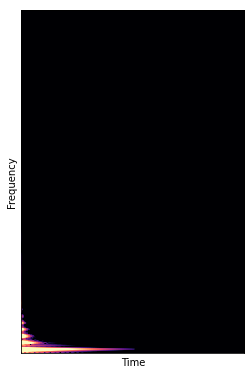

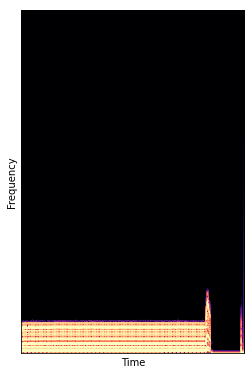

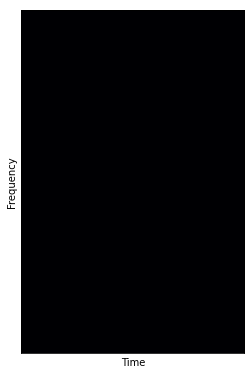

In [24]:
print('Original Audio')
play(audio)
print('Resynthesized Audio')
play(audio_gen)
print('Filtered Noise Audio')
audio_noise = controls['noise']['signal']
play(audio_noise)

specplot(audio)
specplot(audio_gen)
specplot(audio_noise)

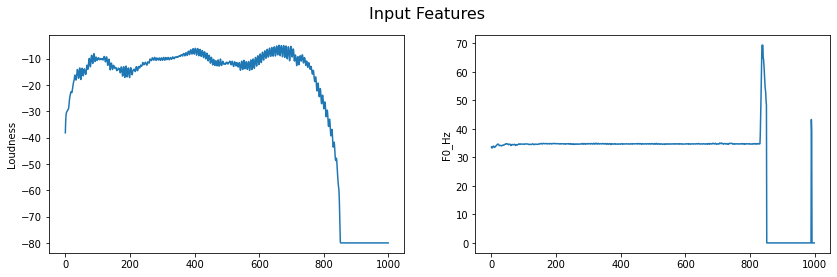

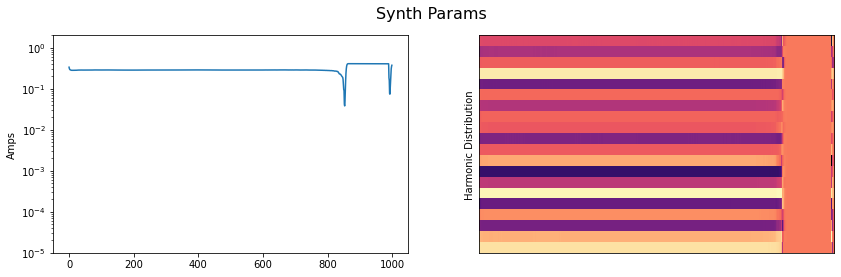

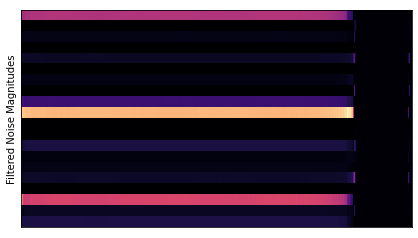

In [25]:
batch_idx = 0
get = lambda key: ddsp.core.nested_lookup(key, controls)[batch_idx]

amps = get('harmonic/controls/amplitudes')
harmonic_distribution = get('harmonic/controls/harmonic_distribution')
noise_magnitudes = get('noise/controls/magnitudes')
f0_hz = get('f0_hz')
loudness = get('loudness_db')

audio_noise = get('noise/signal')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Input Features', fontsize=16)
ax[0].plot(loudness)
ax[0].set_ylabel('Loudness')
ax[1].plot(f0_hz)
ax[1].set_ylabel('F0_Hz')

f, ax = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Synth Params', fontsize=16)
ax[0].semilogy(amps)
ax[0].set_ylabel('Amps')
ax[0].set_ylim(1e-5, 2)
# ax[0].semilogy(harmonic_distribution)
ax[1].matshow(np.rot90(np.log10(harmonic_distribution + 1e-6)),
              cmap=plt.cm.magma, 
              aspect='auto')
ax[1].set_ylabel('Harmonic Distribution')
ax[1].set_xticks([])
_ = ax[1].set_yticks([])

f, ax = plt.subplots(1, 1, figsize=(7, 4))
# f.suptitle('Filtered Noise Params', fontsize=16)
ax.matshow(np.rot90(np.log10(noise_magnitudes + 1e-6)), 
           cmap=plt.cm.magma, 
           aspect='auto')
ax.set_ylabel('Filtered Noise Magnitudes')
ax.set_xticks([])
_ = ax.set_yticks([])
